In [1]:
#Spatially explicit metapopulation version of the model

using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots


#Calculate the probabilities of getting an offspring with trait k when the gametes with 'trait 
#value' i an j are combined

function qgprob(n::Int64)
    
    #All possible phenotypes
    pheno= collect(1:(2*n+1)) ./ (2*n+1)
    nt=length(pheno)

    G=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
                m=collect(0:min(j,k,i+j-k))
                G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
    end

    for k in 0:n
        G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
        for i1 in 0:n
            G[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
             ind_haplR[1+i,1+k] = G[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
         R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                             ind_haplR[1+j,1+q .- (0:q)])
    end
        
    return R
end
    
    
#Function to simulate population dynamics
    
function multipop(Ns::Vector{Float64},r::Vector{Float64},K::Vector{Float64},R::Array{Float64},
                    mmat::Matrix{Float64},pa::Float64,SST::Matrix{Float64})
        
    tsteps=size(SST)[1]
        
    nloci=(size(R)[1]-1)/2
    pheno= collect(1:(2*nloci+1)) ./ (2*nloci+1)
        
    N=rand(Uniform(0,1.0),length(Ns),size(R)[1])
    Ng0= N ./ sum(eachcol(N))
    Np0= Ng0 .* Ns 
    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0)

    #Set up optimal traits value change with time using SST data
    #Initial value is the population mean (this assumes that the local populations are 
    #already adapted to the local temperature).
        
    topt0= [sum(pheno .* Np[x,:])/sum(Np[x,:]) for x in 1:size(Np)[1]]

    topts=topt0 .+ (1.2 .* SST')
        
    #precalculate selection pressure on phenotypes across time steps
    probsurv=zeros(Float64, tsteps, length(Ns), length(pheno))
        
    [probsurv[x,y,:]=exp.(-((topts[y,x] .-pheno) .^2) ./ 0.16) for x in 1:tsteps, y in 1:length(Ns) ]
     
    #Store results
    res=zeros(Float64,tsteps+1,length(Ns),length(pheno))

    res[1,:,:]=Np0

    for t in 1:tsteps
            
        if sum(floor.(Np))<1
                break
        
        else

            #Selection event
            
            Np=Np .* (probsurv[t,:,:])

            #Reproduction event

            if(pa<1)

                newgen=zeros(Float64,length(Ns),length(pheno))

                for i in 1:size(Ngen)[1]
                    
                    Ngen[i,:]=Np[i,:]/sum(Np[i,:])

                    probs=Ngen[i,:]*(Ngen[i,:]')

                    for j in 1:size(Ngen)[2]

                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end

                    Np[i,:]=((pa*sum(Np[i,:])) .* Ngen[i,:]) + (((1-pa)*sum(Np[i,:])) .* newgen[i,:])  

                end
            end

            #Settlement

            for i in 1:size(Np)[1]
                    
                #Logistic growth to simulate crowding effect during settlement
                Ngen[i,:]=Np[i,:]/sum(Np[i,:])
                                                        
                Np[i,:]=(sum(Np[i,:])+ (r[i]*sum(Np[i,:])*(1-(sum(Np[i,:])/K[i])))) .* Ngen[i,:]

            end

            #Migration
            #add fraction of populations to each other (uniformly across all phenotypes) according to
            #the migration matrix mmat
            for i in 1:size(Np)[1], j in 1:size(Np)[1]

                Np[i,:] += mmat[i,j] .* Np[j,:]
                
            end
            
            Np[Np .<1 ] .= 0
            
            res[t+1,:,:]=Np

        end
    end
    
    return res
        
end

multipop (generic function with 1 method)

In [2]:
R=qgprob(114)

229×229×229 Array{Float64, 3}:
[:, :, 1] =
 1.0          0.5          0.25         …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5          0.25         0.125           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.25         0.125        0.0625          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.125        0.0625       0.03125         0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0625       0.03125      0.015625        0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.03125      0.015625     0.0078125    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.015625     0.0078125    0.00390625      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0078125    0.00390625   0.00195313      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.00390625   0.00195313   0.000976562     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.00195312   0.000976562  0.000488281     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.000976562  0.000488281  0.000244141  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.000488281  0.000244141  0.00012207      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.000244141  0.00012207   6.1035

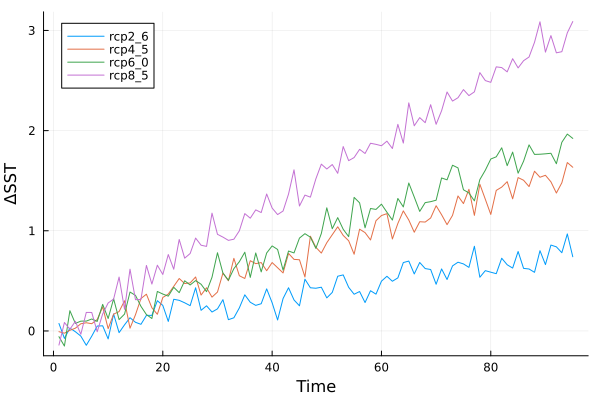

In [8]:
SSTs=DataFrame(rcp2_6=collect(range(start=0,stop=0.775, length=95)),
              rcp4_5=collect(range(start=0,stop=1.6, length=95)),
              rcp6_0=collect(range(start=0,stop=1.925, length=95)),
              rcp8_5=collect(range(start=0,stop=3.0, length=95)))

tsteps=size(SSTs)[1]
       
[ SSTs[:,i] += rand(Normal(0,0.1),size(SSTs)[1]) for i in 1:(size(SSTs)[2]) ]
    
plot(SSTs[:,1], label=names(SSTs)[1],xlabel="Time", ylab=string("ΔSST"))
plot!(SSTs[:,2], label=names(SSTs)[2])
plot!(SSTs[:,3], label=names(SSTs)[3])
plot!(SSTs[:,4], label=names(SSTs)[4])



In [9]:
savefig("SST.png")

"C:\\Users\\mihir\\Documents\\coral_popgen\\codes\\SST.png"

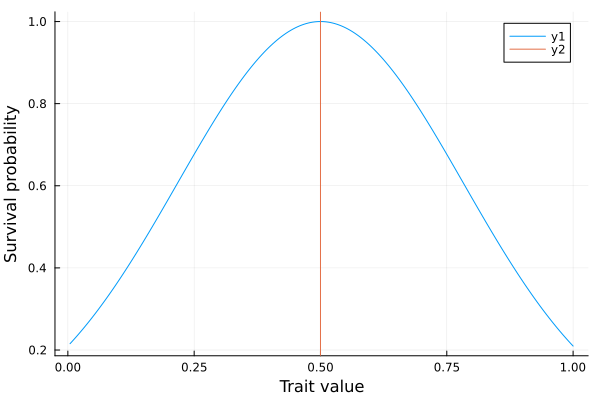

In [15]:
nloci=(size(R)[1]-1)/2
pheno= collect(1:(2*nloci+1)) ./ (2*nloci+1)
survival=exp.(-((0.5 .-pheno) .^2) ./ 0.16)
plot(pheno, survival,xlabel="Trait value",ylabel="Survival probability")
plot!([0.5],seriestype="vline")

In [16]:
savefig("fitness.png")

"C:\\Users\\mihir\\Documents\\coral_popgen\\codes\\fitness.png"

In [ ]:
#Model parameters/Function inputs

#Two populations

popsize=1000.0

#No. subpopulations
Ns=[popsize/3,popsize*2/3]

#Growth rate
r=repeat([1.38],length(Ns))

#Carrying capacity
K=1.2.*Ns

#Proportion of asexually reproducing individuals
pa=0.0

#Migration parameter
ms=collect(0.0:0.05:0.5)

#Migration matrix NpopsXNpops: Indicates the proportion of the population migrating
#from pop i to pop j
#The matrix can be customised with empirical data
#mmat=[0 m;0 0]

#SST data
SSTs=DataFrame(rcp2_6=collect(range(start=0,stop=0.775, length=95)),
              rcp4_5=collect(range(start=0,stop=1.6, length=95)),
              rcp6_0=collect(range(start=0,stop=1.925, length=95)),
              rcp8_5=collect(range(start=0,stop=3.0, length=95)))

tsteps=size(SSTs)[1]
       
[ SSTs[:,i] += rand(Normal(0,0.1),size(SSTs)[1]) for i in 1:(size(SSTs)[2]) ]
    
#plot(SSTs[:,1], label=names(SSTs)[1])
#plot!(SSTs[:,2], label=names(SSTs)[2])
#plot!(SSTs[:,3], label=names(SSTs)[3])
#plot!(SSTs[:,4], label=names(SSTs)[4])

#Run the function for the scenario for the mainland-island dynamic:
#One bigger population (bigger K) which ONLY sends individuals (no immigration) 
#to the smaller island (smaller K).


# Params to vary: pa, mmat,SST

SST=Matrix(SSTs[:,[2,1]])

SSTdat=zeros(Float64,5,size(SSTs)[1],2)
for i in 1:5
    SSTdat[i,:,1]=SSTs[:,1]
    SSTdat[i,:,2]=SSTs[:,1] .+ ((i-1)/20)
end

reps=collect(1:5)

#pars=collect(Iterators.product(reps,ms,collect(1:size(SSTdat)[1])))

pars=collect(Iterators.product(reps,ms, collect(1:5)))




In [ ]:
resdat=DataFrame()


for i in 1:length(pars)
    
    mmat=[0 pars[i][2];0 0]

    res=multipop(Ns,r,K,R,mmat,pa,SSTdat[pars[i][3],:,:])
    
    Ndat=[sum(res[x,:,:]) for x in 1:size(res)[1]]

    hl=findfirst(x-> x< (Ndat[1]/2), Ndat)
    
    append!(resdat,DataFrame(reps=pars[i][1],m=pars[i][2],temp_diff=pars[i][3],halflife=hl))
    

end

In [3]:
collect(0.0:0.25:1.0)

5-element Vector{Float64}:
 0.0
 0.25
 0.5
 0.75
 1.0

In [ ]:
CSV.write("coral_res.csv",resdat)

In [ ]:
#plot results

resdat=CSV.read("coral_res.csv", DataFrame)

pardat=unique(resdat[:,[:m,:temp_diff]])

resdat1=DataFrame()

for i in 1:size(pardat)[1]
    
    m1=pardat.m[i]
    temp_diff1=pardat.temp_diff[i]
    
    dat1=resdat[resdat.m .== m1 .&& resdat.temp_diff .== temp_diff1,:]
    
    append!(resdat1,DataFrame(m=m1,temp_diff=temp_diff1,
            halflife_m=mean(dat1.halflife),halflife_sd=std(dat1.halflife)))
    
end
    


In [ ]:
#Model parameters/Function inputs

#Single population

popsize=1000.0

#No. subpopulations
Ns=[popsize]

#Growth rate
r=[1.38]

#Carrying capacity
K=1.2 .* Ns

#Proportion of asexually reproducing individuals
pa=0

#Migration parameter
ms=collect(0.0:0.1:0.5)

#Migration matrix NpopsXNpops: Indicates the proportion of the population migrating
#from pop i to pop j
#The matrix can be customised with empirical data
#mmat=[0 m;0 0]

#SST data
SSTs=DataFrame(rcp2_6=collect(range(start=0,stop=0.775, length=95)),
              rcp4_5=collect(range(start=0,stop=1.6, length=95)),
              rcp6_0=collect(range(start=0,stop=1.925, length=95)),
              rcp8_5=collect(range(start=0,stop=3.0, length=95)))

tsteps=size(SSTs)[1]
       
[ SSTs[:,i] += rand(Normal(0,0.1),size(SSTs)[1]) for i in 1:(size(SSTs)[2]) ]
    
#plot(SSTs[:,1], label=names(SSTs)[1])
#plot!(SSTs[:,2], label=names(SSTs)[2])
#plot!(SSTs[:,3], label=names(SSTs)[3])
#plot!(SSTs[:,4], label=names(SSTs)[4])

#Run the function for the scenario for the mainland-island dynamic:
#One bigger population (bigger K) which ONLY sends individuals (no immigration) 
#to the smaller island (smaller K).


# Params to vary: pa, mmat

SSTdat=zeros(Float64,5,size(SSTs)[1],2)
for i in 1:5
    SSTdat[i,1,:]=SSTs[:,1]
    SSTdat[i,2,:]=SSTs[:,1] .+ ((i-1)/2)
end

reps=collect(1:10)

pars=collect(Iterators.product(reps,ms,))

resdat=DataFrame()

for i in 1:length(pars)
    
    mmat=[0.0 m;0.0 0.0]

    res=multipop(Ns,r,K,R,mmat,pa,SST)
    
    Ndat=[sum(res[x,:,:]) for x in 1:size(res)[1]]

    hl=findfirst(x-> x< (Ndat[1]/2), Ndat)
    
    append!(resdat,DataFrame(reps=pars[i][1],m=pars[i][2],halflife=hl))
    

end